In [37]:
import pandas as pd
from models import SingleLayer
from torch.nn import MSELoss
from torch.optim import Adam
import torch
from sklearn import preprocessing
import os

In [38]:
merged_df = pd.read_csv('features/merged_df_PCA.csv')

In [39]:
merged_df.head()

,names,Pitch,SpectralCentroid,SpectralSpread,SpectralSkewness,SpectralKurtosis,SpectralFlatness,SpectralCrest,SpectralSlope,SpectralDecrease,...,F1_Hz,F2_Hz,F3_HZ,F4_Hz,Rate,Depth,Regularity,x,y,z
0,bellou_a_1,294.792756,1988.705488,1236.076582,0.667607,2.230896,6.130028e-05,0.166799,8.356768e-08,0.034523,...,965.355185,1566.595113,3081.040174,3536.460589,0.628707,0.031815,0.095775,9.317695,0.621495,-1.054224
1,bellou_a_2,224.575582,1191.358861,663.951795,1.619319,6.378916,1.482950e-09,0.309095,2.968422e-06,0.019057,...,899.487838,1495.686633,2559.188944,3348.608822,1.938681,0.015600,0.041192,2.236056,-6.705590,-4.355881
2,bellou_a_3,215.427334,1630.110589,1201.959572,1.233063,3.561876,3.840608e-04,0.198526,-8.364649e-07,0.028277,...,978.654497,1669.361870,3239.718778,4173.536668,3.915128,0.061797,0.434528,7.544067,-0.588950,-0.268951
3,bellou_a_4,310.702620,1215.894880,740.676596,1.352175,4.917070,1.353494e-03,0.247989,-1.853757e-06,0.043431,...,949.317310,1712.827614,2029.906806,3230.486712,8.998951,0.029717,0.463241,7.945791,-0.237960,-2.450706
4,bellou_a_5,326.715388,1111.645409,576.713488,1.669873,6.963033,4.287648e-09,0.394933,4.004495e-06,0.021064,...,966.616790,1598.766626,2945.418491,3379.549015,4.379635,0.035155,0.176779,8.613728,-1.355972,-2.128227


In [40]:
# 0-1 scaling
# merged_df.iloc[:,1:]=(merged_df.iloc[:,1:]-merged_df.iloc[:,1:].min())/(merged_df.iloc[:,1:].max()-merged_df.iloc[:,1:].min())

In [41]:
# standard scaling
# merged_df.iloc[:,1:]=(merged_df.iloc[:,1:]-merged_df.iloc[:,1:].mean())/merged_df.iloc[:,1:].std()
merged_df.iloc[:,1:-3]=(merged_df.iloc[:,1:-3]-merged_df.iloc[:,1:-3].mean())/merged_df.iloc[:,1:-3].std()

In [42]:
merged_df.head()

,names,Pitch,SpectralCentroid,SpectralSpread,SpectralSkewness,SpectralKurtosis,SpectralFlatness,SpectralCrest,SpectralSlope,SpectralDecrease,...,F1_Hz,F2_Hz,F3_HZ,F4_Hz,Rate,Depth,Regularity,x,y,z
0,bellou_a_1,0.480408,1.670548,1.087304,-1.037823,-0.975735,-0.030604,-1.095087,-0.134589,0.253587,...,1.469111,-0.023067,1.175261,-0.008615,-0.857007,-0.377392,-0.736266,9.317695,0.621495,-1.054224
1,bellou_a_2,-0.302836,-0.159822,-1.077907,0.144168,0.205507,-0.158334,0.215598,1.321186,-0.370189,...,1.172474,-0.184804,-0.456812,-0.699232,-0.351538,-0.395970,-1.008558,2.236056,-6.705590,-4.355881
2,bellou_a_3,-0.404881,0.847366,0.958188,-0.335548,-0.596708,0.641943,-0.802847,-0.598862,0.001676,...,1.529005,0.211335,1.671524,2.333528,0.411097,-0.343042,0.953650,7.544067,-0.588950,-0.268951
3,bellou_a_4,0.657876,-0.103498,-0.787542,-0.187616,-0.210786,2.661982,-0.347245,-1.112215,0.612844,...,1.396883,0.310476,-2.112125,-1.133496,2.372750,-0.379797,1.096889,7.945791,-0.237960,-2.450706
4,bellou_a_5,0.836492,-0.342811,-1.408062,0.206954,0.371848,-0.158328,1.006252,1.844017,-0.289242,...,1.474793,0.050313,0.751109,-0.585484,0.590333,-0.373566,-0.332167,8.613728,-1.355972,-2.128227


In [43]:
corrs_df = merged_df.iloc[:,1:].corr()
corrs_df.to_csv('features/corrs_all.csv')

In [44]:
train_x = merged_df.iloc[:,1:-3].values
train_y = merged_df.iloc[:,-3:].values
x = torch.from_numpy(train_x).float()
y = torch.from_numpy(train_y).float()

In [45]:
# labels = list(merged_df['names'].str.split('_').str[0])
labels = list(merged_df['names'])
for i,l in enumerate(labels):
    if l.split('_')[1] == 'old':
        labels[i] = l.split('_')[0] + '_' + 'old'
    else:
        labels[i] = l.split('_')[0]
# d = {ni: indi for indi, ni in enumerate(set(labels))}
d = {'bellou': 0,
     'bithikotsis': 1,
     'keti': 2,
     'kazantzidis': 3,
     'kazantzidis_old': 4,
     'ninou': 5,
     'tsaousakis': 6
}
print(d)
ids = [d[ni] for ni in labels]
print(ids)

{'bellou': 0, 'bithikotsis': 1, 'keti': 2, 'kazantzidis': 3, 'kazantzidis_old': 4, 'ninou': 5, 'tsaousakis': 6}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [46]:
# singer_labels = list(set(labels))
singer_labels = list(d.keys())
print(singer_labels)

['bellou', 'bithikotsis', 'keti', 'kazantzidis', 'kazantzidis_old', 'ninou', 'tsaousakis']


In [47]:
target_x = list(merged_df['x'])
target_y = list(merged_df['y'])
target_z = list(merged_df['z'])

In [48]:
import matplotlib.pyplot as plt

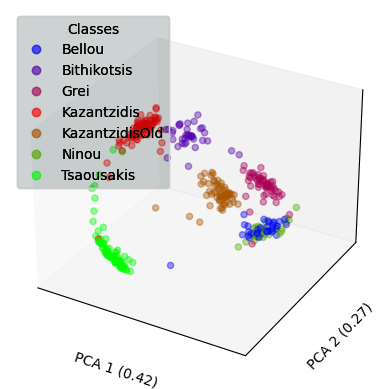

In [49]:
# fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(target_x, target_y, target_z, marker='o', c=ids, cmap='brg', alpha=0.4)

# ax.scatter(target_x, target_z, marker='x', c=ids, cmap='rainbow', alpha=0.4, zdir='y')
# ax.scatter(target_y, target_z, marker='x', c=ids, cmap='rainbow', alpha=0.4, zdir='x')
# ax.scatter(target_x, target_y, marker='x', c=ids, cmap='rainbow', alpha=0.4, zdir='z')

legends = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
legends.get_frame().set_alpha(None)
legends.get_frame().set_facecolor((0, 0.1, 0.1, 0.1))
for i,t in enumerate(legends.get_texts()):
    t.set_text( singer_labels[i].replace('keti', 'grei').capitalize().replace('_old', 'Old') )
ax.add_artist(legends)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel('PCA 1 (0.42)')
ax.set_ylabel('PCA 2 (0.27)')
ax.set_zlabel('PCA 3 (0.17)', rotation=90)
ax.zaxis.labelpad=-4

In [50]:
os.makedirs('figs', exist_ok=True)
fig.savefig('figs/pca_hubert_7_classes.png', dpi=300)

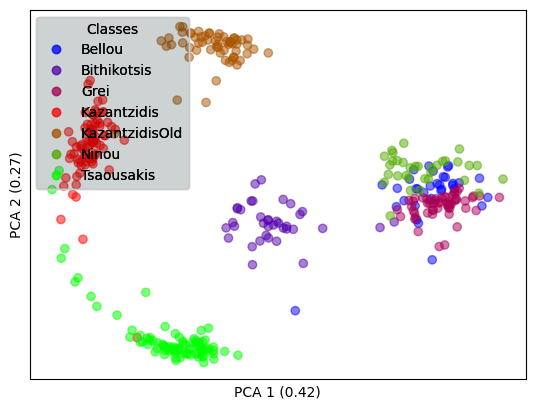

In [51]:
fig = plt.figure()
ax = fig.add_subplot()

scatter = ax.scatter(target_x, target_y, marker='o', c=ids, cmap='brg', alpha=0.5)

# ax.scatter(target_x, target_z, marker='x', c=ids, cmap='rainbow', alpha=0.4, zdir='y')
# ax.scatter(target_y, target_z, marker='x', c=ids, cmap='rainbow', alpha=0.4, zdir='x')
# ax.scatter(target_x, target_y, marker='x', c=ids, cmap='rainbow', alpha=0.4, zdir='z')

legends = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
legends.get_frame().set_alpha(None)
legends.get_frame().set_facecolor((0, 0.1, 0.1, 0.1))
for i,t in enumerate(legends.get_texts()):
    t.set_text( singer_labels[i].replace('keti', 'grei').capitalize().replace('_old', 'Old') )
ax.add_artist(legends)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PCA 1 (0.42)')
ax.set_ylabel('PCA 2 (0.27)')
fig.savefig('figs/pca12_7_classes.png', dpi=300)

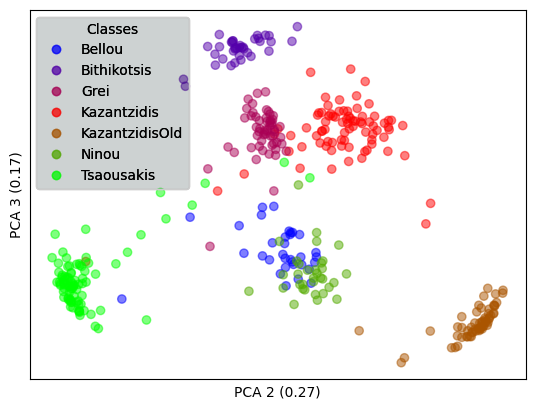

In [52]:
fig = plt.figure()
ax = fig.add_subplot()

scatter = ax.scatter(target_y, target_z, marker='o', c=ids, cmap='brg', alpha=0.5)

# ax.scatter(target_x, target_z, marker='x', c=ids, cmap='rainbow', alpha=0.4, zdir='y')
# ax.scatter(target_y, target_z, marker='x', c=ids, cmap='rainbow', alpha=0.4, zdir='x')
# ax.scatter(target_x, target_y, marker='x', c=ids, cmap='rainbow', alpha=0.4, zdir='z')

legends = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
legends.get_frame().set_alpha(None)
legends.get_frame().set_facecolor((0, 0.1, 0.1, 0.1))
for i,t in enumerate(legends.get_texts()):
    t.set_text( singer_labels[i].replace('keti', 'grei').capitalize().replace('_old', 'Old') )
ax.add_artist(legends)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PCA 2 (0.27)')
ax.set_ylabel('PCA 3 (0.17)')
fig.savefig('figs/pca23_7_classes.png', dpi=300)

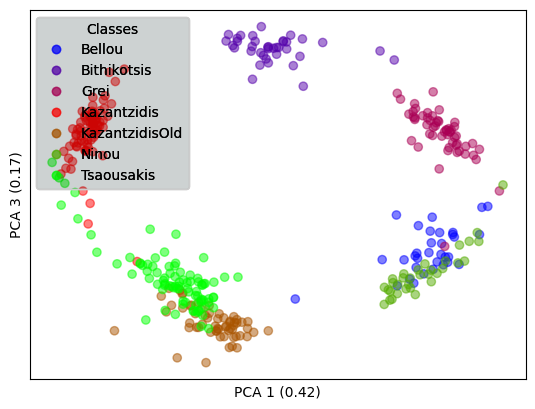

In [53]:
fig = plt.figure()
ax = fig.add_subplot()

scatter = ax.scatter(target_x, target_z, marker='o', c=ids, cmap='brg', alpha=0.5)

# ax.scatter(target_x, target_z, marker='x', c=ids, cmap='rainbow', alpha=0.4, zdir='y')
# ax.scatter(target_y, target_z, marker='x', c=ids, cmap='rainbow', alpha=0.4, zdir='x')
# ax.scatter(target_x, target_y, marker='x', c=ids, cmap='rainbow', alpha=0.4, zdir='z')

legends = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
legends.get_frame().set_alpha(None)
legends.get_frame().set_facecolor((0, 0.1, 0.1, 0.1))
for i,t in enumerate(legends.get_texts()):
    t.set_text( singer_labels[i].replace('keti', 'grei').capitalize().replace('_old', 'Old') )
ax.add_artist(legends)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PCA 1 (0.42)')
ax.set_ylabel('PCA 3 (0.17)')
fig.savefig('figs/pca13_7_classes.png', dpi=300)

In [54]:
import numpy as np

In [55]:
# correlation of each feature with the PCs
corrs = {}
for i, c in enumerate(merged_df.columns):
    # print(i, c)
    if i > 0 and i < len(merged_df.columns) - 3:
        # print('yes')
        corr_x = merged_df[c].corr(merged_df['x'])
        corr_y = merged_df[c].corr(merged_df['y'])
        corr_z = merged_df[c].corr(merged_df['z'])
        corrs[c] = {'x': corr_x , 'y': corr_y , 'z': corr_z }

In [56]:
print(corrs)

{'Pitch': {'x': 0.6978810528525586, 'y': 0.07236561542258221, 'z': 0.07760891295044176}, 'SpectralCentroid': {'x': 0.14474716138309227, 'y': -0.19621776565101315, 'z': 0.30499424496147387}, 'SpectralSpread': {'x': 0.025845664480291006, 'y': -0.199101638713154, 'z': 0.29616970229993295}, 'SpectralSkewness': {'x': -0.07654475415364265, 'y': 0.21381159687763213, 'z': -0.18277381808974838}, 'SpectralKurtosis': {'x': -0.04560737402456599, 'y': 0.18221702834402367, 'z': -0.17878540745272203}, 'SpectralFlatness': {'x': 0.02853385091962804, 'y': 0.1262758323446398, 'z': -0.0672004841054542}, 'SpectralCrest': {'x': 0.1553683496260584, 'y': 0.29087338561240905, 'z': -0.3011373393884337}, 'SpectralSlope': {'x': -0.03252157342260822, 'y': -0.34984647377625094, 'z': 0.1521101500413872}, 'SpectralDecrease': {'x': 0.1776455454288935, 'y': 0.41069225443872487, 'z': -0.3562683664144864}, 'SpectralRollOff': {'x': 0.13966212267387842, 'y': -0.14708955631789328, 'z': 0.22985683960498837}, 'SpectralVariati

In [57]:
x_corrs = []
y_corrs = []
z_corrs = []
labs = list(corrs.keys())
for k in labs:
    x_corrs.append(corrs[k]['x'])
    y_corrs.append(corrs[k]['y'])
    z_corrs.append(corrs[k]['z'])
y_pos = np.arange(len(labs))

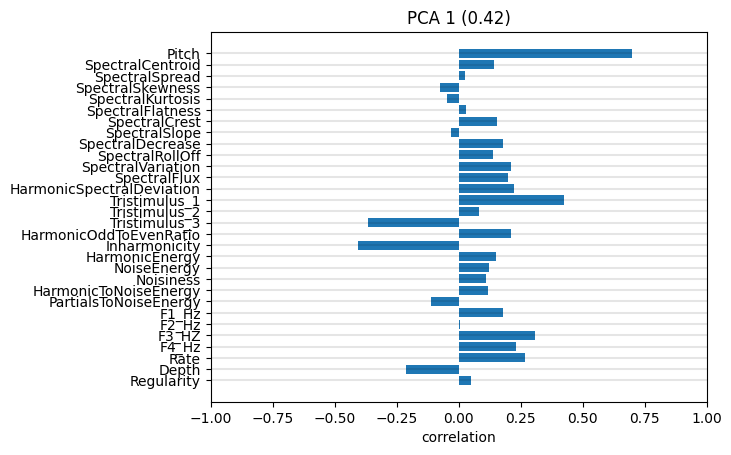

In [58]:
fig, ax = plt.subplots()

for i in y_pos:
    ax.plot([-1,1],[i,i],'-', c='k', alpha=0.1)
ax.barh(y_pos, x_corrs, align='center')
ax.set_yticks(y_pos, labels=labs)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('correlation')
ax.set_title('PCA 1 (0.42)')
ax.set_xlim([-1,1])

plt.show()
fig.savefig('figs/pca_1_corrs.png', bbox_inches='tight', dpi=300)

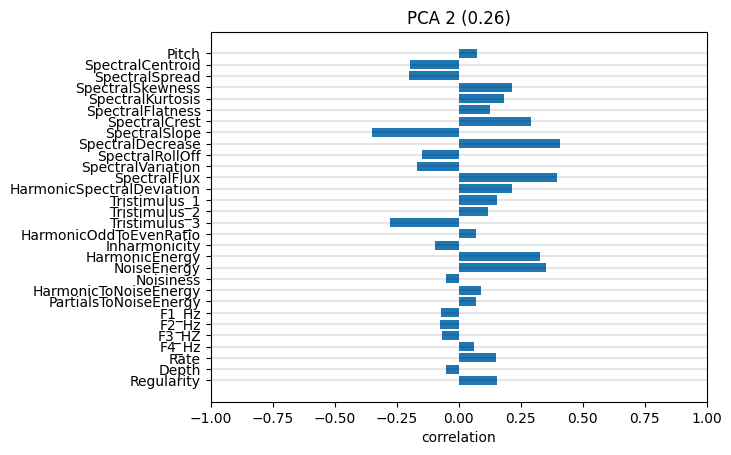

In [59]:
fig, ax = plt.subplots()

for i in y_pos:
    ax.plot([-1,1],[i,i],'-', c='k', alpha=0.1)
ax.barh(y_pos, y_corrs, align='center')
ax.set_yticks(y_pos, labels=labs)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('correlation')
ax.set_title('PCA 2 (0.26)')
ax.set_xlim([-1,1])

plt.show()
fig.savefig('figs/pca_2_corrs.png', bbox_inches='tight', dpi=300)

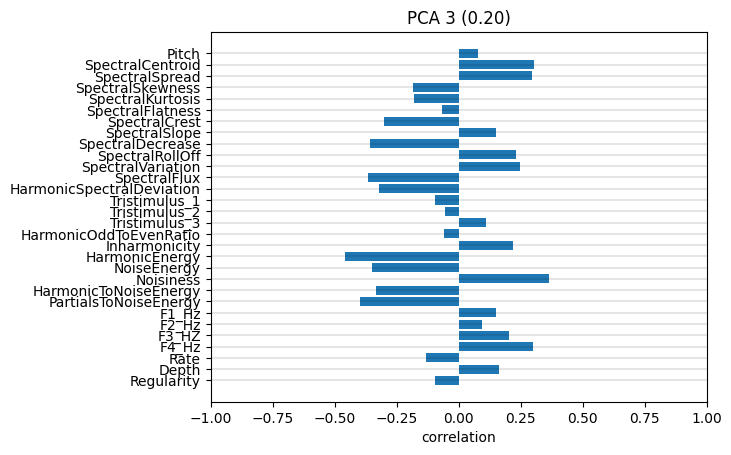

In [60]:
fig, ax = plt.subplots()

for i in y_pos:
    ax.plot([-1,1],[i,i],'-', c='k', alpha=0.1)
ax.barh(y_pos, z_corrs, align='center')
ax.set_yticks(y_pos, labels=labs)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('correlation')
ax.set_title('PCA 3 (0.20)')
ax.set_xlim([-1,1])

plt.show()
fig.savefig('figs/pca_3_corrs.png', bbox_inches='tight', dpi=300)

In [61]:
labs = np.array(labs)
corr_lim = 0.4
x_corrs = np.array(x_corrs)
x_strong = x_corrs[ np.abs(x_corrs) > corr_lim ]
x_names_strong = labs[np.abs(x_corrs) > corr_lim]
y_corrs = np.array(y_corrs)
y_strong = y_corrs[ np.abs(y_corrs) > corr_lim ]
y_names_strong = labs[np.abs(y_corrs) > corr_lim]
y_strong
z_corrs = np.array(z_corrs)
z_strong = z_corrs[ np.abs(z_corrs) > corr_lim ]
z_names_strong = labs[np.abs(z_corrs) > corr_lim]

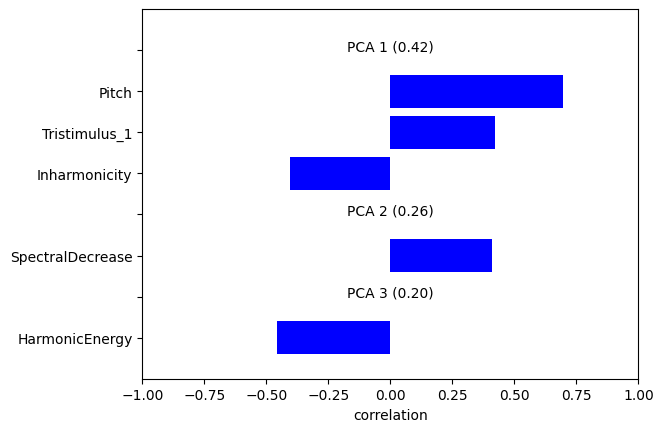

In [62]:
strong_labs = []
y_pos_strong = []
tmp_y = 0
y_pos_strong.append(tmp_y)
fig, ax = plt.subplots()
# PCA 1
ax.text(0, tmp_y, 'PCA 1 (0.42)', horizontalalignment='center')
strong_labs.append('')
for i in range(len(x_strong)):
    tmp_y += 1
    y_pos_strong.append(tmp_y)
    strong_labs.append(x_names_strong[i])
    ax.barh(tmp_y, x_strong[i], color='b', align='center')
# PCA 2
tmp_y += 1
y_pos_strong.append(tmp_y)
ax.text(0, tmp_y, 'PCA 2 (0.26)', horizontalalignment='center')
strong_labs.append('')
for i in range(len(y_strong)):
    tmp_y += 1
    y_pos_strong.append(tmp_y)
    strong_labs.append(y_names_strong[i])
    ax.barh(tmp_y, y_strong[i], color='b', align='center')
# PCA 3
tmp_y += 1
y_pos_strong.append(tmp_y)
ax.text(0, tmp_y, 'PCA 3 (0.20)', horizontalalignment='center')
strong_labs.append('')
for i in range(len(z_strong)):
    tmp_y += 1
    y_pos_strong.append(tmp_y)
    strong_labs.append(z_names_strong[i])
    ax.barh(tmp_y, z_strong[i], color='b', align='center')

ax.set_yticks(y_pos_strong, labels=strong_labs)
ax.set_xlabel('correlation')
# ax.set_title('PCA 3 (0.20)')
ax.set_xlim([-1,1])
ax.set_ylim([-1,len(y_pos_strong)])
ax.invert_yaxis()  # labels read top-to-bottom

plt.show()
fig.savefig('figs/pca_all_corrs.png', bbox_inches='tight', dpi=300)

In [63]:
from correlation import bartlett_sphericity, kmo

In [64]:
chi2,ddl,pvalue = bartlett_sphericity(merged_df.iloc[:,1:-3], corr_method="spearman")

n_p_ratio:    12.83


/media/datadisk/python/audio_singer_classification/correlation.py:103: UserWarning: NOTE: we advise  to  use  this  test  only  if  the number of instances (n) divided by the number of variables (p) is lower than 5. Please try the KMO test, for example.
  warnings.warn("NOTE: we advise  to  use  this  test  only  if  the number of instances (n) divided by the number of variables (p) is lower than 5. Please try the KMO test, for example.")


In [65]:
print(chi2, ddl, pvalue)

14004.158372723967 435.0 0.0


In [66]:
cc = merged_df.iloc[:,1:-3].corr()

In [67]:
value,per_variable = kmo(cc)

In [68]:
print(value, per_variable)

0.7173730830927688 [0.6209810326314542, 0.7314212609678924, 0.7696316850143293, 0.6382865749505777, 0.6122946201733979, 0.5213246018133743, 0.8357357125746594, 0.46442884411609103, 0.7032188602665587, 0.9348790375092084, 0.7496248278687633, 0.8194510024226073, 0.8587201032325609, 0.5280738116151038, 0.6088904529263302, 0.64802838667633, 0.7660116762152874, 0.769404046849695, 0.8293042174070043, 0.7684882543947461, 0.6870902872714533, 0.7952703691810781, 0.6981462418648033, 0.6947332289552405, 0.7704869338155725, 0.6249233751143136, 0.6185170491772015, 0.6731859604567896, 0.5440621960245609, 0.7197349528132777]
